In [1]:
# general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
import json
import warnings

In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [3]:
# extras
from IPython.display import clear_output
from time import time
from time import sleep

In [4]:
# importing functions
from embedding import SimilarityEmbedding, VICRegLoss, train_one_epoch_se, val_one_epoch_se
from data_processing import Paper_data

In [5]:
# checking gpu status, ensures tensors are stored on the same device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


# Data Loading

In [6]:
# load in tensors

data_shifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper4.pt')
data_unshifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper4.pt')
param_shifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper4.pt')
param_unshifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper4.pt')

In [7]:
# define the dataset

num_batches_paper_sample = len(data_shifted_paper)
dataset_paper = Paper_data(data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper, num_batches_paper_sample)

In [8]:
# split dataset into training, testing, and validation

num_batches_paper_sample = len(data_shifted_paper)

train_set_size_paper = int(0.8 * num_batches_paper_sample)    
val_set_size_paper = int(0.1 * num_batches_paper_sample)     
test_set_size_paper = num_batches_paper_sample - train_set_size_paper - val_set_size_paper

train_data_paper, val_data_paper, test_data_paper = torch.utils.data.random_split(
    dataset_paper, [train_set_size_paper, val_set_size_paper, test_set_size_paper])

In [9]:
# load and shuffle the data

train_data_loader_paper = DataLoader(train_data_paper, batch_size=25, shuffle=True)
val_data_loader_paper = DataLoader(val_data_paper, batch_size=25, shuffle=True)
test_data_loader_paper = DataLoader(test_data_paper, batch_size=1, shuffle=False)

# Training

In [10]:
similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=2).to(device)
num_dim = 7

# optimizes
optimizer = optim.Adam(similarity_embedding.parameters(), lr=0.000004)

# define the loss
vicreg_loss = VICRegLoss()

# sets learning rate steps
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5) #constant lr
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3) #one cycle - increase and then decrease
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 15])

In [11]:
# print neural network parameters that require gradients and sum parameters

sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.numel())
        sum_param+=param.numel()
print(sum_param)

layer_norm.weight
363
layer_norm.bias
363
layers_f.conv1.weight
1344
layers_f.bn1.weight
64
layers_f.bn1.bias
64
layers_f.residual_layers.0.0.conv1.weight
20480
layers_f.residual_layers.0.0.bn1.weight
64
layers_f.residual_layers.0.0.bn1.bias
64
layers_f.residual_layers.0.0.conv2.weight
20480
layers_f.residual_layers.0.0.bn2.weight
64
layers_f.residual_layers.0.0.bn2.bias
64
layers_f.residual_layers.0.1.conv1.weight
20480
layers_f.residual_layers.0.1.bn1.weight
64
layers_f.residual_layers.0.1.bn1.bias
64
layers_f.residual_layers.0.1.conv2.weight
20480
layers_f.residual_layers.0.1.bn2.weight
64
layers_f.residual_layers.0.1.bn2.bias
64
layers_f.residual_layers.1.0.conv1.weight
40960
layers_f.residual_layers.1.0.bn1.weight
128
layers_f.residual_layers.1.0.bn1.bias
128
layers_f.residual_layers.1.0.conv2.weight
81920
layers_f.residual_layers.1.0.bn2.weight
128
layers_f.residual_layers.1.0.bn2.bias
128
layers_f.residual_layers.1.0.downsample.0.weight
8192
layers_f.residual_layers.1.0.downsamp

In [12]:
# write to tensorboard

writer = SummaryWriter()
epoch_number = 0

In [13]:
%%time
# training the neural network for many epochs

epoch_number = 0
EPOCHS = 50

sim_val_loss = []
sim_train_loss = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    wt_repr, wt_cov, wt_std = (1, 1, 1)

    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch_se(epoch_number, writer, train_data_loader_paper, similarity_embedding,
                                        optimizer, vicreg_loss, wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_train_loss.append(avg_train_loss)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    similarity_embedding.eval()
    avg_val_loss = val_one_epoch_se(epoch_number, writer, val_data_loader_paper, similarity_embedding,
                                    vicreg_loss, wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_val_loss.append(avg_val_loss)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()


EPOCH 1:
 Avg. train loss/batch after 10 batches = 0.9884
Last 0.00; 0.00; 0.99
 Avg. train loss/batch after 20 batches = 0.9851
Last 0.00; 0.00; 0.98
 Avg. train loss/batch after 30 batches = 0.9815
Last 0.00; 0.00; 0.98
 Avg. train loss/batch after 40 batches = 0.9770
Last 0.00; 0.00; 0.97
 Avg. train loss/batch after 50 batches = 0.9715
Last 0.00; 0.00; 0.96
 Avg. train loss/batch after 60 batches = 0.9646
Last 0.00; 0.00; 0.95
 Avg. train loss/batch after 70 batches = 0.9571
Last 0.00; 0.00; 0.95
 Avg. train loss/batch after 80 batches = 0.9498
Last 0.01; 0.00; 0.94
 Avg. train loss/batch after 90 batches = 0.9393
Last 0.01; 0.00; 0.92
 Avg. train loss/batch after 100 batches = 0.9277
Last 0.01; 0.00; 0.92
 Avg. train loss/batch after 110 batches = 0.9162
Last 0.02; 0.00; 0.89
 Avg. train loss/batch after 120 batches = 0.9086
Last 0.02; 0.00; 0.88
 Avg. train loss/batch after 130 batches = 0.8922
Last 0.02; 0.00; 0.86
 Avg. train loss/batch after 140 batches = 0.8838
Last 0.03; 0.0

/home/mmdesai/.conda/envs/my_torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


 Avg. train loss/batch after 10 batches = 0.0788
Last 0.06; 0.00; 0.00
 Avg. train loss/batch after 20 batches = 0.0954
Last 0.03; 0.00; 0.00
 Avg. train loss/batch after 30 batches = 0.0683
Last 0.05; 0.00; 0.00
 Avg. train loss/batch after 40 batches = 0.0926
Last 0.05; 0.00; 0.00
 Avg. train loss/batch after 50 batches = 0.0828
Last 0.07; 0.00; 0.00
 Avg. train loss/batch after 60 batches = 0.0903
Last 0.11; 0.00; 0.00
 Avg. train loss/batch after 70 batches = 0.0733
Last 0.06; 0.00; 0.00
 Avg. train loss/batch after 80 batches = 0.0875
Last 0.08; 0.00; 0.00
 Avg. train loss/batch after 90 batches = 0.0608
Last 0.05; 0.00; 0.00
 Avg. train loss/batch after 100 batches = 0.0575
Last 0.06; 0.00; 0.00
 Avg. train loss/batch after 110 batches = 0.0545
Last 0.05; 0.00; 0.00
 Avg. train loss/batch after 120 batches = 0.0501
Last 0.04; 0.00; 0.00
 Avg. train loss/batch after 130 batches = 0.0514
Last 0.04; 0.00; 0.00
 Avg. train loss/batch after 140 batches = 0.0381
Last 0.05; 0.00; 0.00
T

Text(0, 0.5, 'Loss')

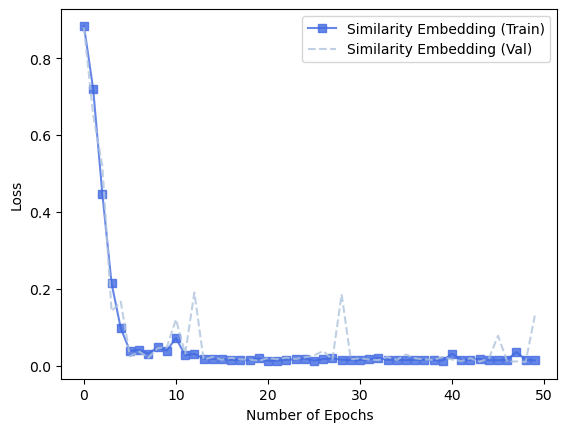

In [14]:
# plot the train/val loss 

epoch_list = range(0,len(sim_train_loss))
plt.plot(epoch_list, sim_train_loss, label = 'Similarity Embedding (Train)', color = 'royalblue', alpha = 0.8, marker = 's')
plt.plot(epoch_list, sim_val_loss, label = 'Similarity Embedding (Val)', color = 'lightsteelblue', alpha=0.8, linestyle="dashed")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')